In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

# 1- write a script that simulates positive control data 

W MATRIX -
each row represents a gene, and each column represents a module. Each row should have a non-zero
entry in only one column – unless it is a moonlighting gene in which case it should have a non-zero value in two
columns. Each column should sum to one.

In [9]:
#W matrix is N col and R rows 
N=100 #nb of genes - the rows 
R=5 #nb of modules - the col 
#H matrix 
#rows are R 
M= 50 #number of col -number of experiements
Moonlight_genes_nb=3
C=100000 

In [10]:
def generate_random_Wmatrix(N,R,Moonlight_genes_nb=3):
    w_matrix= np.zeros((N,R)) #initialisation
    moonlight_genes_indexes=np.random.choice(range(len(w_matrix)),Moonlight_genes_nb)
    moonlight_genes_indexes
    gene_index=0
    for gene in w_matrix:
        if gene_index in moonlight_genes_indexes : 

            non_zero_module_indexes=np.random.choice(range(R), size=2, replace=False)
            weights_for_moonlight_genes=np.random.dirichlet(np.ones(2))

            gene[non_zero_module_indexes[0]]= weights_for_moonlight_genes[0]
            gene[non_zero_module_indexes[1]]= weights_for_moonlight_genes[1]
        else :
            non_zero_module_index=np.random.choice(range(R))
            gene[non_zero_module_index]=1
        gene_index+=1
    w_matrix/=w_matrix.sum(axis=0)
    return w_matrix
#np.apply_along_axis(np.sum,0,w_matrix) #test this should give an array of 5 ones    

In [11]:
w_matrix_true=generate_random_Wmatrix(N=100,R=5,Moonlight_genes_nb=3)

In [12]:
def generate_random_Hmatrix(R,M,C=100000):
    h_matrix=np.random.dirichlet(np.ones(R),size=M).T #this is proba matrix
    #np.apply_along_axis(np.sum,0,h_matrix) #test this should give an array of 50 ones
    h_matrix*=C #this is now in tpm 
    return h_matrix

In [13]:
h_matrix_true=generate_random_Hmatrix(R=5,M=50,C=100000)

In [14]:
v_matrix_whitout_noise=np.dot(w_matrix_true,h_matrix_true)
#now lets add poisson noise
v_matrix_true=np.random.poisson(v_matrix_whitout_noise)
#how far from non poission noise 
v_diff_poisson=v_matrix_whitout_noise-v_matrix_true


# question 2

-log( obeservation | 2 matrices) =-log(v|w,h)

In [88]:
def NMF_test(v_matrix,R):
    run_numbers=100
    nll_delta_threshold=0.00001 #this is a value that i arbitraty choose 
    N=v_matrix.shape[0] #get the N and M from the matrix V putted as input of the function 
    M=v_matrix.shape[1]
    count_array=v_matrix.sum(axis=0) #sum over col is the count 
    minimum_nll=float('inf')
    for r in range(run_numbers):
       # print('run number',r)
        delta_nll = float('inf') #initial difference in old and new nll set to infiny 
        nll_old=float(0)
       #step 1 initialisation of random h and W - start with new estimate for every runs
        h_current=generate_random_Hmatrix(R,M,C) #initial estimate
        w_current=generate_random_Wmatrix(N,R)
        v_current=(w_current@h_current) #@ is matrix multiplcation in pyton 3 
        v_current=np.where(v_current==0,0.001,v_current) #replace entries 0 (if any) by 0.001 -to be able to take the log  - just random in the intial step anyways 


        #now that we have the inital random guess for W, H and therefore V lets iterate until convergence
        nb_of_iterations=0
        while delta_nll>nll_delta_threshold:
            #optimization-update W and H
            ratio_matrix=np.divide(v_matrix,v_current)
            Ht_c=(h_current*count_array).T
            w_new=w_current*(ratio_matrix@Ht_c)#new estimate = old*ratiomatrix*Count*Transpose of h
            w_new/=w_new.sum() # normalise - divide each term by the sum of the 
    
            h_new=h_current*(w_current.T@ratio_matrix)# 
            v_new=w_new@h_new
           
             #now NLL for this itteration
            matrix_to_be_summed=v_matrix*np.log(v_new)-(v_new)
            nll =matrix_to_be_summed.sum()
            #print('nll new',nll) #tracking
            #print('nll_old',nll_old) #tracking/pbshooting
            delta_nll =abs(nll-nll_old) #compare to NLL in the previous iteration
            #print('delta_nll',delta_nll)
            nll_old = nll
            h_current=h_new
            w_current=w_new
            v_current=v_new
            nb_of_iterations+=1
        final_nll_for_run = nll  
        print('for run',r+1,'it converged after',nb_of_iterations,'iterations')
        #print('final_nll_for_this_run',final_nll_for_run)
        #print('minimum_nll',minimum_nll)
        if final_nll_for_run < minimum_nll:
            print('permutation in run number',r+1)
            minimum_nll = float(final_nll_for_run)
            h_best=h_current
            w_best=w_current
            v_best=v_current
            print('the new minimal nll so far is ',final_nll_for_run)
    return (h_best,w_best,v_best,minimum_nll)    
            


In [89]:
h_output_test,w_output_test,v_output_test,nll_ouput_test=NMF_test(v_matrix=v_matrix_true,R=5) #tried on my generate V matrix that has been generated in the first part 

for run 1 it converged after 70 iterations
permutation in run number 1
the new minimal nll so far is  25999694.31345175
for run 2 it converged after 101 iterations
permutation in run number 2
the new minimal nll so far is  25929097.133349296
for run 3 it converged after 114 iterations
for run 4 it converged after 152 iterations
for run 5 it converged after 263 iterations
for run 6 it converged after 54 iterations
for run 7 it converged after 221 iterations
permutation in run number 7
the new minimal nll so far is  25913692.558745515
for run 8 it converged after 141 iterations
permutation in run number 8
the new minimal nll so far is  25904519.532511752
for run 9 it converged after 158 iterations
for run 10 it converged after 96 iterations
for run 11 it converged after 128 iterations
for run 12 it converged after 332 iterations
for run 13 it converged after 1075 iterations
for run 14 it converged after 160 iterations
for run 15 it converged after 140 iterations
for run 16 it converged a

same function just without the prints etc - now that we check that its working proprely and also runing this test function multiple time - the highest runs where a permutation happened was at run number 58 so ill set a limit at run 60 and remove the prints statements in the next coding cells

In [90]:
def NMF(v_matrix,R, nll_delta_threshold=0.1,run_numbers=60 ):
    N=v_matrix.shape[0] #get the N and M from the matrix V putted as input of the function 
    M=v_matrix.shape[1]
    count_array=v_matrix.sum(axis=0) #sum over col is the count 
    minimum_nll=float('inf')
    for r in range(run_numbers):
      
        delta_nll = float('inf') #initial difference in old and new nll set to infiny 
        nll_old=float(0)
       #step 1 initialisation of random h and W - start with new estimate for every runs
        h_current=generate_random_Hmatrix(R,M,C) #initial estimate
        w_current=generate_random_Wmatrix(N,R)
        v_current=(w_current@h_current) #@ is matrix multiplcation in pyton 3 
        v_current=np.where(v_current==0,0.001,v_current) #replace entries 0 (if any) by 0.001 -to be able to take the log  - just random in the intial step anyways 


        #now that we have the inital random guess for W, H and therefore V lets iterate until convergence
        nb_of_iterations=0
        while delta_nll>nll_delta_threshold:
            #optimization-update W and H
            ratio_matrix=np.divide(v_matrix,v_current)
            Ht_c=(h_current*count_array).T
            w_new=w_current*(ratio_matrix@Ht_c)#new estimate = old*ratiomatrix*Count*Transpose of h
            w_new/=w_new.sum() # normalise - divide each term by the sum of the 
    
            h_new=h_current*(w_current.T@ratio_matrix)# 
            v_new=w_new@h_new
           
             #now NLL for this itteration
            matrix_to_be_summed=v_matrix*np.log(v_new)-(v_new)
            nll =matrix_to_be_summed.sum()
            delta_nll =abs(nll-nll_old) #compare to NLL in the previous iteration
      
            nll_old = nll
            h_current=h_new
            w_current=w_new
            v_current=v_new
            nb_of_iterations+=1
        final_nll_for_run = nll  
   
        if final_nll_for_run < minimum_nll:
 
            minimum_nll = float(final_nll_for_run)
            h_best=h_current
            w_best=w_current
            v_best=v_current
    return (h_best,w_best,v_best,minimum_nll)    

lets try with different r values
(takes a bit of time )


In [91]:
h_output_3,w_output_3,v_output_3,nll_ouput_3=NMF(v_matrix=v_matrix_true,R=3)
h_output_4,w_output_4,v_output_4,nll_ouput_4=NMF(v_matrix=v_matrix_true,R=4)
h_output_5,w_output_5,v_output_5,nll_ouput_5=NMF(v_matrix=v_matrix_true,R=5)
h_output_6,w_output_6,v_output_6,nll_ouput_6=NMF(v_matrix=v_matrix_true,R=6)
h_output_7,w_output_7,v_output_7,nll_ouput_7=NMF(v_matrix=v_matrix_true,R=7)
h_output_8,w_output_8,v_output_8,nll_ouput_8=NMF(v_matrix=v_matrix_true,R=8)
h_output_9,w_output_9,v_output_9,nll_ouput_9=NMF(v_matrix=v_matrix_true,R=9)
h_output_10,w_output_10,v_output_10,nll_ouput_10=NMF(v_matrix=v_matrix_true,R=10)


In [92]:
print('nll with R=3',nll_ouput_3)
print('nll with R=4',nll_ouput_4)
print('nll with R=5',nll_ouput_5)
print('nll with R=6',nll_ouput_6)
print('nll with R=7',nll_ouput_7)
print('nll with R=8',nll_ouput_8)
print('nll with R=9',nll_ouput_9)
print('nll with R=10',nll_ouput_10)

nll with R=3 27723837.61978148
nll with R=4 26718032.050346337
nll with R=5 25874698.634904254
nll with R=6 25181949.911201086
nll with R=7 24541410.609462358
nll with R=8 23953889.72760331
nll with R=9 23535430.859077618
nll with R=10 23095152.79306156


In [93]:
R_values=[3,4,5,6,7,8,9,10]
nll_ouputs=[nll_ouput_3,nll_ouput_4,nll_ouput_5,nll_ouput_6,nll_ouput_7,nll_ouput_8,nll_ouput_9,nll_ouput_10]

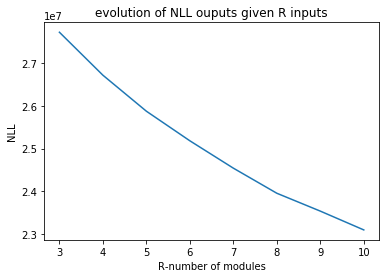

In [94]:
plt.plot(R_values,nll_ouputs)
plt.title('evolution of NLL ouputs given R inputs')
plt.xlabel('R-number of modules')
plt.ylabel('NLL')
plt.show()

this is not super infromative and dont really tell us much about how good our model is doing nor what is the best R (i think there is a problem because im not expecting the NLL to continue decreasing after reaching the correct value for R - I would have expected it to be a plateau)

In [22]:
#normalise on the colum(first just because it makes more sense to me to analayis ans understand) 
w_matrix_true_col=w_matrix_true/(w_matrix_true.sum(axis=0))
w_output_3_col=w_output_3/w_output_3.sum(axis=0)
w_output_4_col=w_output_4/w_output_4.sum(axis=0)
w_output_5_col=w_output_5/w_output_5.sum(axis=0)
w_output_6_col=w_output_6/w_output_6.sum(axis=0)

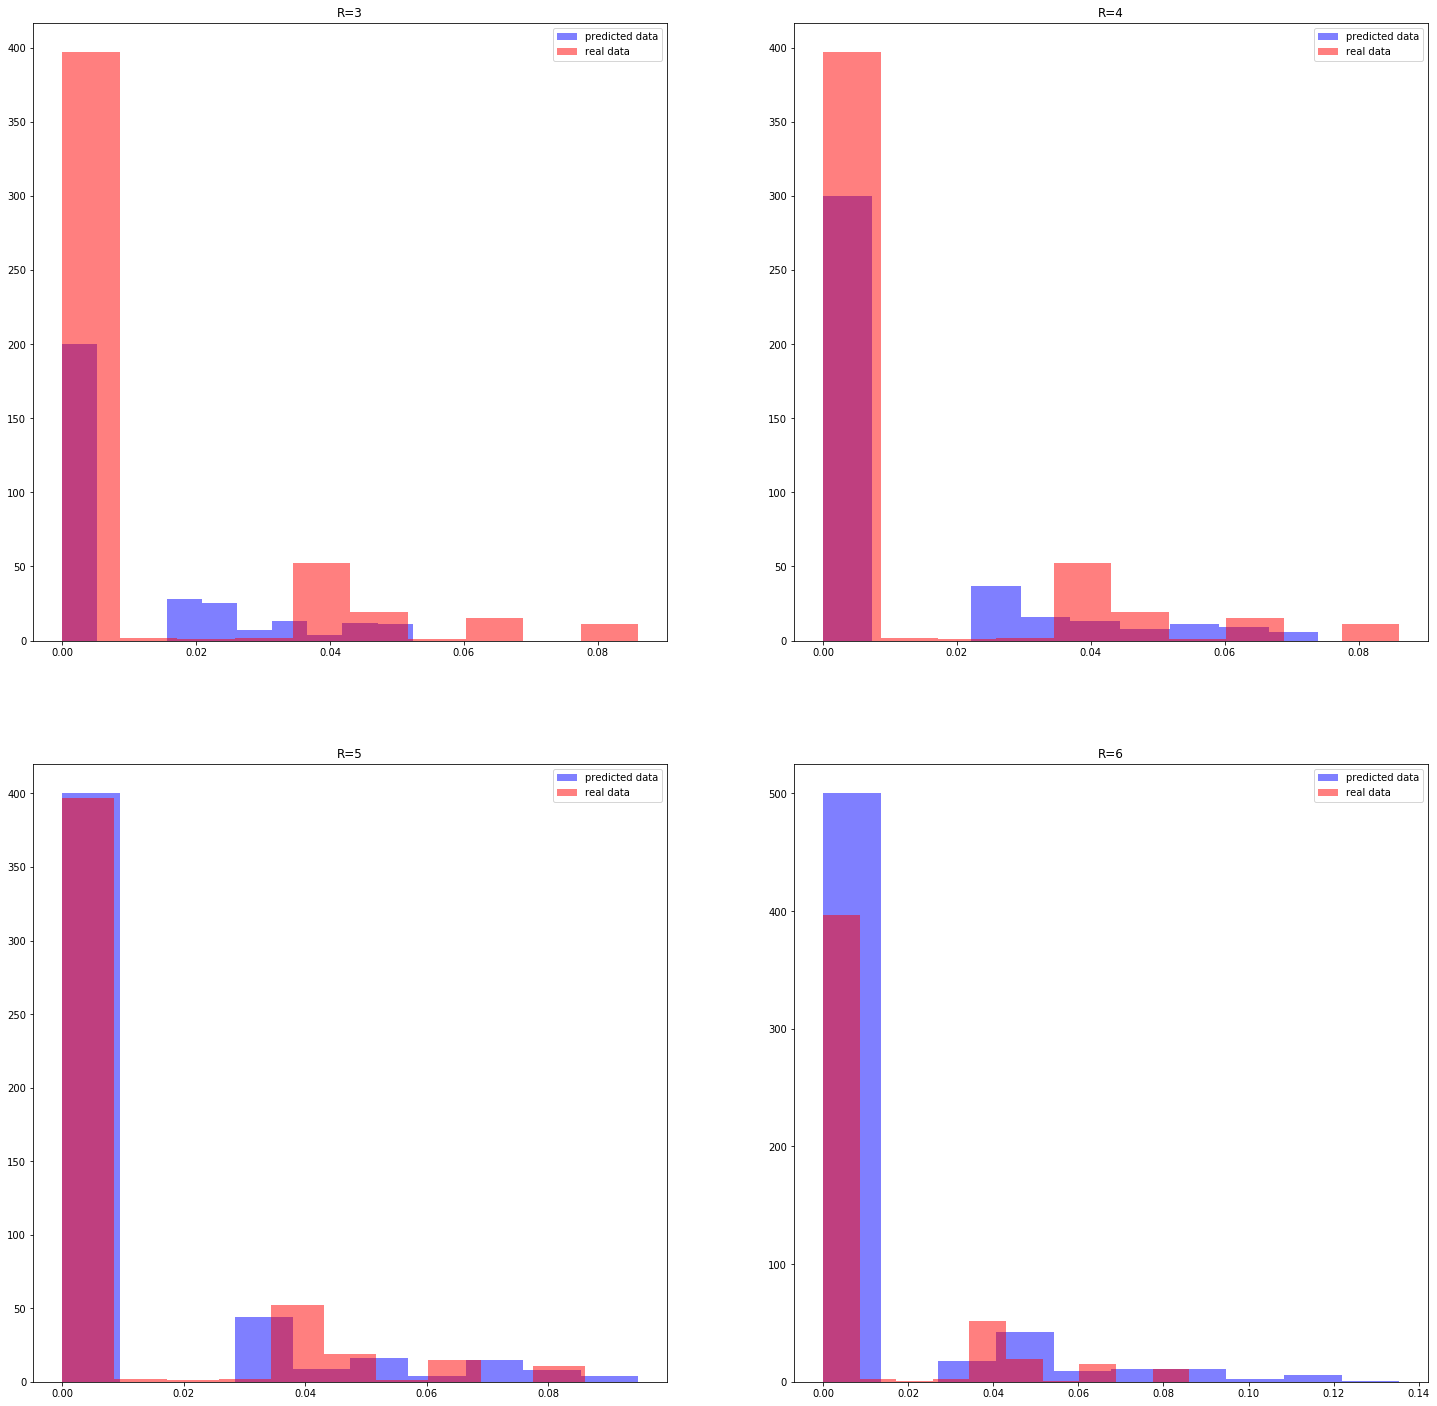

In [23]:

fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(w_output_3_col.flatten(), alpha=0.5,color = "blue",label='predicted data')
axs[0, 0].hist(w_matrix_true_col.flatten(), alpha=0.5,color = "red",label='real data')
axs[0, 0].set_title('R=3')
axs[0, 0].legend()

axs[0, 1].hist(w_output_4_col.flatten(), alpha=0.5,color = "blue",label='predicted data')
axs[0, 1].hist(w_matrix_true_col.flatten(), alpha=0.5,color = "red",label='real data')
axs[0, 1].set_title('R=4')
axs[0, 1].legend()

axs[1, 0].hist(w_output_5_col.flatten(), alpha=0.5,color = "blue",label='predicted data')
axs[1, 0].hist(w_matrix_true_col.flatten() ,alpha=0.5,color = "red",label='real data')
axs[1, 0].set_title('R=5')
axs[1, 0].legend()

axs[1, 1].hist(w_output_6_col.flatten(), alpha=0.5,color = "blue",label='predicted data')
axs[1, 1].hist(w_matrix_true_col.flatten(), alpha=0.5,color = "red",label='real data')
axs[1, 1].set_title('R=6')
axs[1, 1].legend()


fig.set_figheight(25)
fig.set_figwidth(25)    
plt.show()



#the proportion of the gene attributed to each module is closer to the read case with R=5 - so this is confirming that our model is working
#the difference is due to noise (poisson noise that we added in the first part )



In [24]:
#normalise on the rows(to confirm that our model is working proprely(and the most over lap happens at R=5, the R we used to generate our observed data in the first place )) 
w_matrix_true_row=w_matrix_true/(w_matrix_true.sum(axis=1))[:, None] #[:, None] to convert(100,) to (100,1) 
w_output_3_row=w_output_3/w_output_3.sum(axis=1)[:, None]
w_output_4_row=w_output_4/w_output_4.sum(axis=1)[:, None]
w_output_5_row=w_output_5/w_output_5.sum(axis=1)[:, None]
w_output_6_row=w_output_6/w_output_6.sum(axis=1)[:, None]

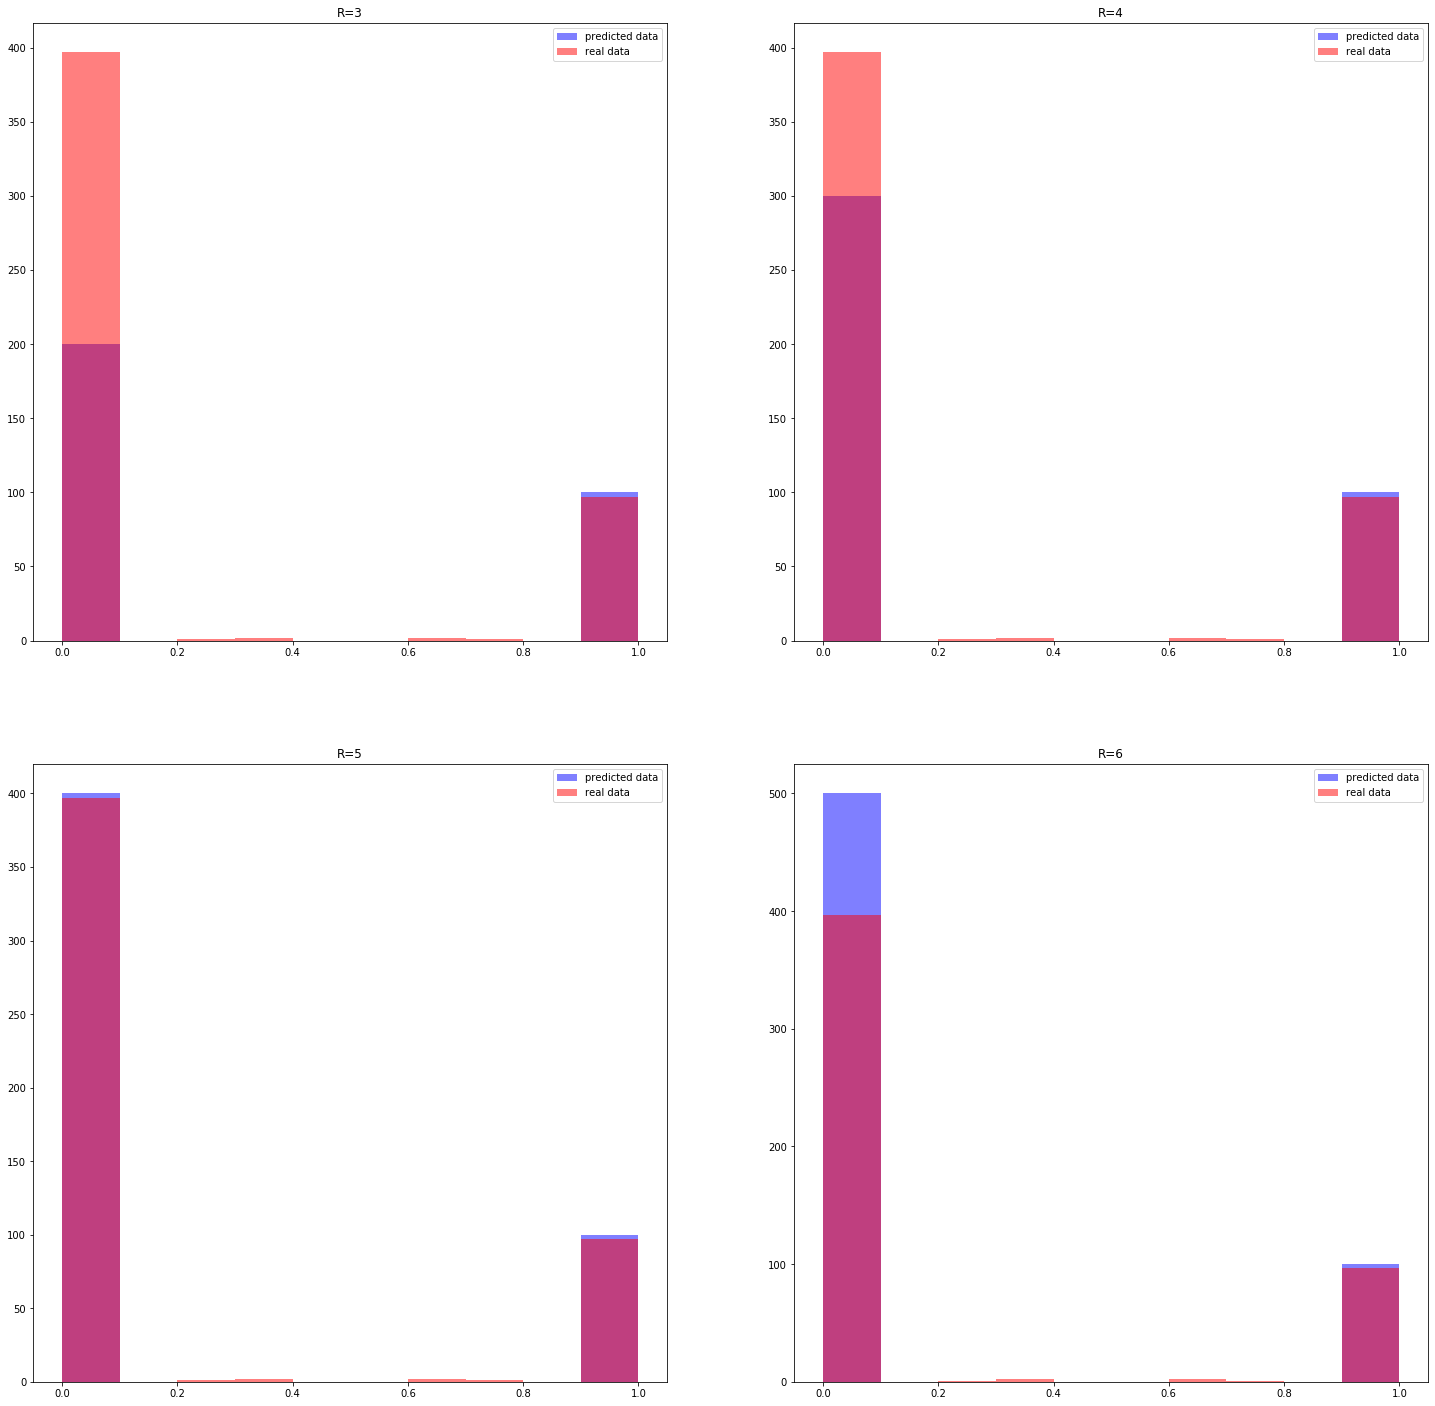

In [25]:

fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(w_output_3_row.flatten(), alpha=0.5,color = "blue",label='predicted data')
axs[0, 0].hist(w_matrix_true_row.flatten(), alpha=0.5,color = "red",label='real data')
axs[0, 0].set_title('R=3')
axs[0, 0].legend()

axs[0, 1].hist(w_output_4_row.flatten(), alpha=0.5,color = "blue",label='predicted data')
axs[0, 1].hist(w_matrix_true_row.flatten(), alpha=0.5,color = "red",label='real data')
axs[0, 1].set_title('R=4')
axs[0, 1].legend()

axs[1, 0].hist(w_output_5_row.flatten(), alpha=0.5,color = "blue",label='predicted data')
axs[1, 0].hist(w_matrix_true_row.flatten() ,alpha=0.5,color = "red",label='real data')
axs[1, 0].set_title('R=5')
axs[1, 0].legend()

axs[1, 1].hist(w_output_6_row.flatten(), alpha=0.5,color = "blue",label='predicted data')
axs[1, 1].hist(w_matrix_true_row.flatten(), alpha=0.5,color = "red",label='real data')
axs[1, 1].set_title('R=6')
axs[1, 1].legend()


fig.set_figheight(25)
fig.set_figwidth(25)    
plt.show()


overlaps better with R=5 so this confirms that our model is correct-now lets try to recover the moonlight genes using heatmaps


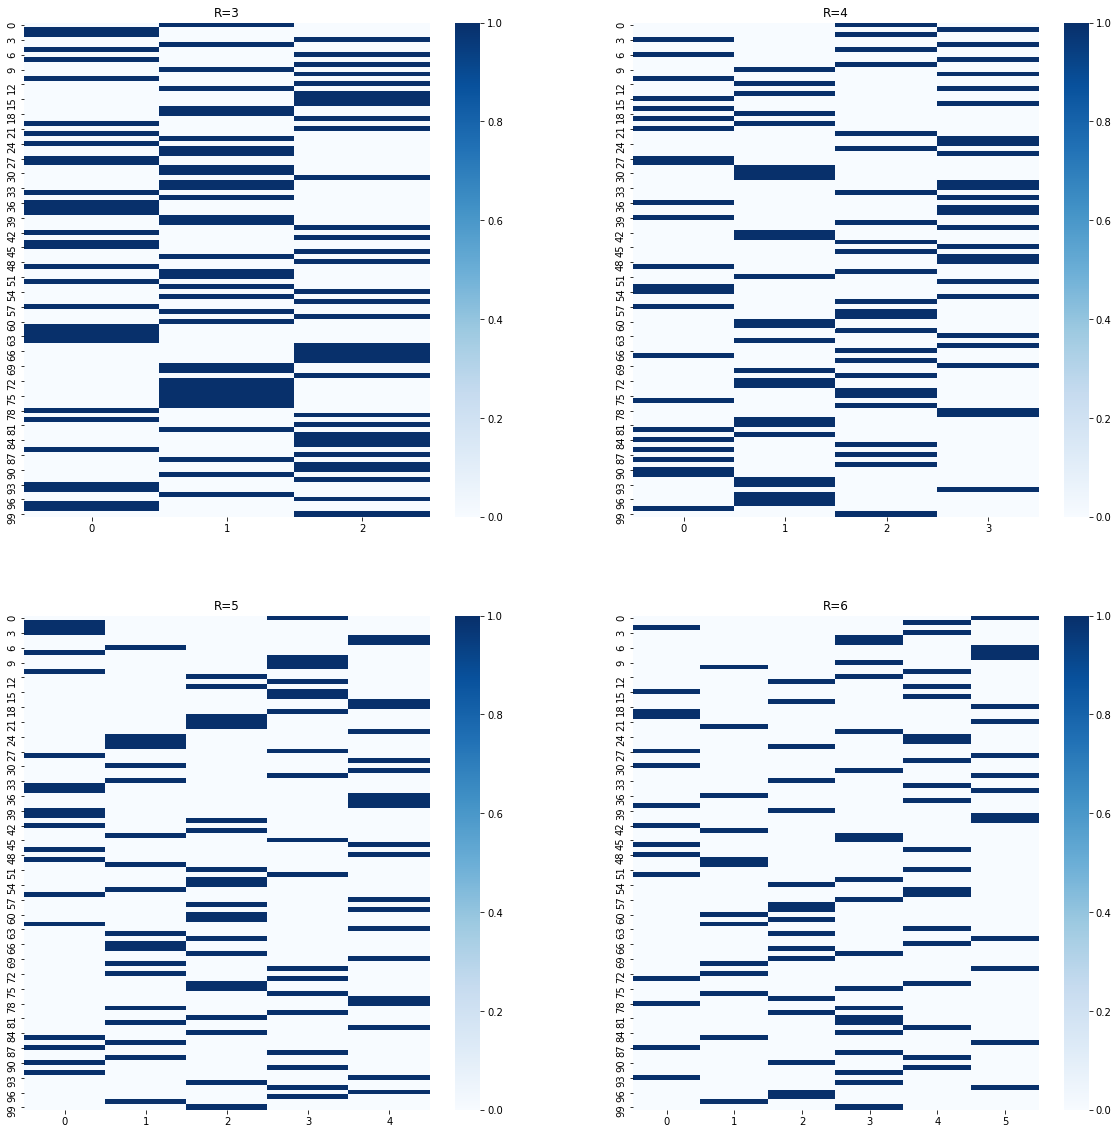

In [85]:
fig, axs = plt.subplots(2,2,figsize=(20,20))

sns.heatmap(w_output_3_row,cmap='Blues',ax=axs[0, 0]).set_title('R=3')
sns.heatmap(w_output_4_row,cmap='Blues',ax=axs[0, 1]).set_title('R=4')
sns.heatmap(w_output_5_row,cmap='Blues',ax=axs[1, 0]).set_title('R=5')
sns.heatmap(w_output_6_row,cmap='Blues',ax=axs[1, 1]).set_title('R=6')

plt.show()

I think i have done something wrong in my estimate because i can recover the index of the moonlight genes(genes expressed in multiple modules have the same indexes as moonlight_genes_indexes

# part 3

Please note that im aware my next results might be wrong because my estimates in the second parts are wrong - I couldnt detect the bug but i still wanted to do part 3 just to show how i would tackle the question if my results were correct in part 2(also if you can find the bug (i think its a snmall thing) you will be able to run this part and get the expected results i think)

In [101]:
RNA_Seq_data=pd.read_csv('w09-data.tbl',header= None, index_col= 0, skiprows=0,sep="\s+")
#RNA_Seq_data

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
0,,,,,,,,,,,,,,,,,,,,,
anise,1375,1491,410,246,1479,313,151,650,36,2339,...,914,336,69,40,455,6,787,311,1658,1092
apricot,10,220,26,120,76,444,310,0,75,234,...,414,50,140,359,466,160,108,452,147,96
artichoke,1750,2590,726,4144,2474,627,1433,171,2340,45,...,98,1336,3785,1188,516,2161,698,1815,2540,2634
arugula,926,1392,388,2248,1376,336,737,92,1273,29,...,65,676,2176,614,274,1228,376,1009,1363,1458
asparagus,551,584,133,119,600,125,68,256,12,946,...,386,136,33,16,182,6,332,149,659,430
avocado,627,912,207,1470,914,218,538,55,822,26,...,33,495,1461,399,194,818,218,646,943,902
banana,318,357,76,76,354,82,36,137,13,544,...,261,102,16,5,126,0,219,79,374,248
basil,2465,2501,640,496,2648,530,283,1173,81,4256,...,1771,612,160,61,873,12,1491,606,2914,1965
beet,516,534,126,105,582,111,57,249,18,864,...,388,138,22,12,183,7,322,127,615,397


step 1- from tbl to matrix that can be used as an argument of the function i created in part 2 

In [27]:
adler_data = pd.read_table('w09-data.tbl',delim_whitespace=True,comment="#",header=None)
adler_data=adler_data.apply(pd.to_numeric, errors='coerce')
adler_matrix=adler_data.values
adler_matrix=np.delete(adler_matrix, 0, 1)

/Users/leinaessakalli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


using this matrix lets run the function and varrying R ( R takes the value of 3,4,5,6,10)
takes a bit of time to run- sorry
also i will run with a different  nll_delta_threshold ( its to be able to identify moonlight genes later)
sorry it takes a while to run

In [71]:
h_adler3,w_adler3,v_adler3,nll_adler3=NMF(v_matrix=adler_matrix,R=3,nll_delta_threshold=100,run_numbers=5)
h_adler4,w_adler4,v_adler4,nll_adler4=NMF(v_matrix=adler_matrix,R=4,nll_delta_threshold=100,run_numbers=5)
h_adler5,w_adler5,v_adler5,nll_adler5=NMF(v_matrix=adler_matrix,R=5,nll_delta_threshold=100,run_numbers=5)
h_adler6,w_adler6,v_adler6,nll_adler6=NMF(v_matrix=adler_matrix,R=6,nll_delta_threshold=100,run_numbers=5)
h_adler10,w_adler10,v_adler10,nll_adler10=NMF(v_matrix=adler_matrix,R=10,nll_delta_threshold=100,run_numbers=5)

Lets first see how varrying R would vary the min NLL (but given my expereience in the past part this wouldnt be enough to determine what is the optimal R )

In [72]:
R_value_Adler=[3,4,5,6,10]
nll_test_Adler=[nll_adler3,nll_adler4,nll_adler5,nll_adler6,nll_adler10]

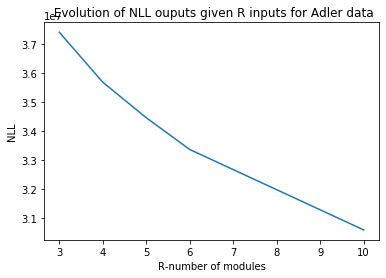

In [73]:
plt.plot(R_value_Adler,nll_test_Adler)
plt.title(' Evolution of NLL ouputs given R inputs for Adler data')
plt.xlabel('R-number of modules')
plt.ylabel('NLL')
plt.show()

As excpected no suffisant to choose the right number of modules

In [74]:
w_adler3_test=(w_adler3)/w_adler3.sum(axis=1)[:, None]
w_adler4_test=(w_adler4)/w_adler4.sum(axis=1)[:, None]
w_adler5_test=(w_adler5)/w_adler5.sum(axis=1)[:, None]
w_adler6_test=(w_adler6)/w_adler6.sum(axis=1)[:, None]

x=module, y=gene
if gene in multiple module its a moonlight gene

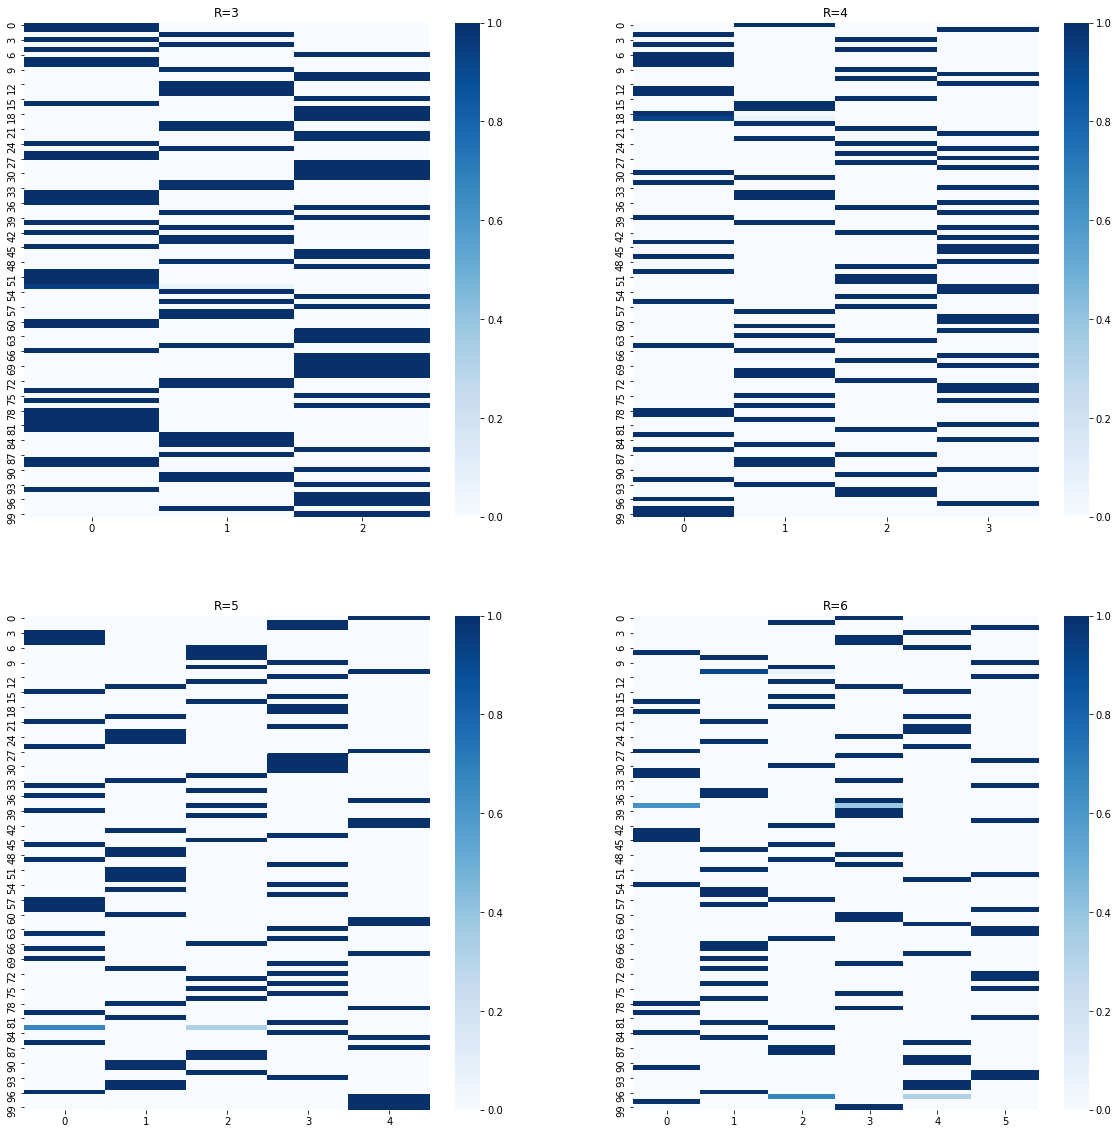

In [75]:


fig, axs = plt.subplots(2,2,figsize=(20,20))

sns.heatmap(w_adler3_test,cmap='Blues',ax=axs[0, 0]).set_title('R=3')
sns.heatmap(w_adler4_test,cmap='Blues',ax=axs[0, 1]).set_title('R=4')
sns.heatmap(w_adler5_test,cmap='Blues',ax=axs[1, 0]).set_title('R=5')
sns.heatmap(w_adler6_test,cmap='Blues',ax=axs[1, 1]).set_title('R=6')

plt.show()


the plot above are showing that when R=4 there are some genes has a proba to be attributed to a module that is not equal to 1 or 0 for all modules- those are moolight genes and this is the correct R 

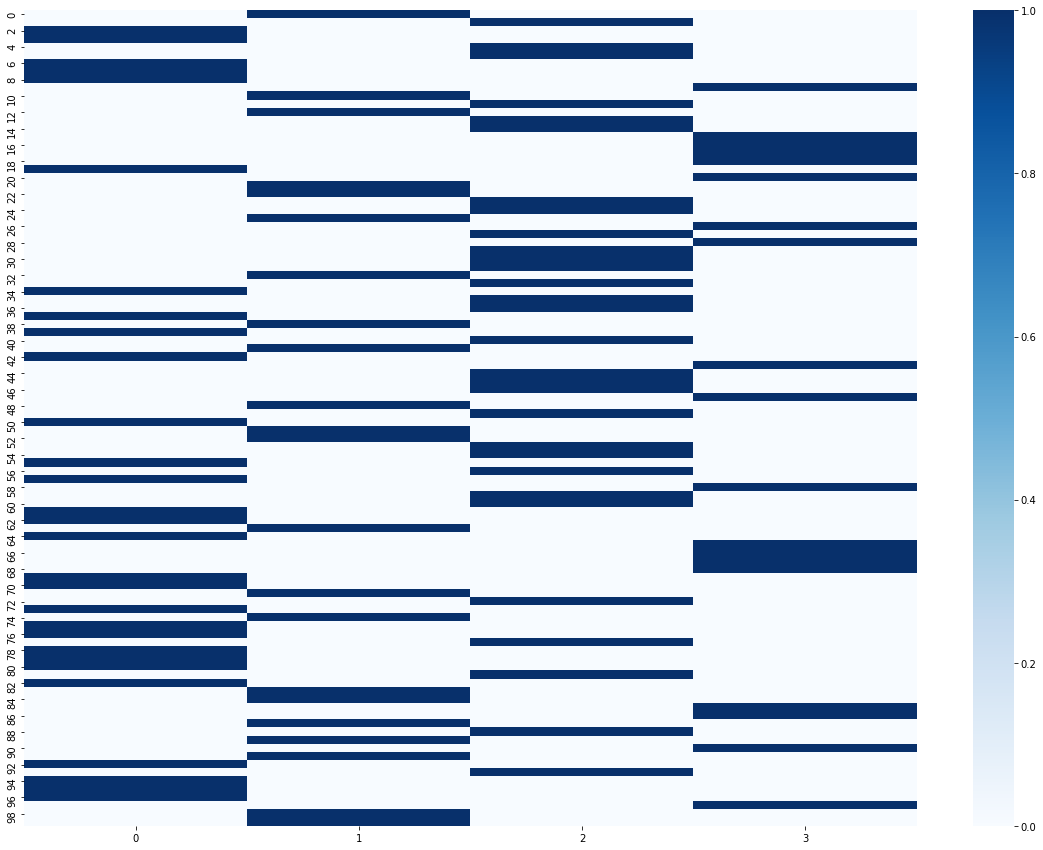

In [68]:
plt.subplots(figsize=(20,15))
sns.heatmap(w_adler4_test,cmap='Blues')
plt.show()

Ok so from this plot we can extrract the gene of interest - (this is the results i got when i runed it but i know it might be wrong given the mistake i made before)

- gene index21 expressed both in module 0 and 2),

- gene index 50 expressed both in module 0 and 3 

- gene index 70 expressed in both modules 1 and 2 

In [96]:
moonlight_gene_index_adler=[21,50,70]

In [97]:
RNA_Seq_data.iloc[moonlight_gene_index_adler,:]

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
0,,,,,,,,,,,,,,,,,,,,,
cherry,63,49,14,7,64,11,8,28,1,97,...,37,8,8,1,18,0,33,17,73,50
lentil,55,71,14,11,65,13,5,33,4,91,...,50,11,7,4,24,0,39,9,80,58
pear,241,237,60,51,266,49,29,114,7,375,...,175,61,15,11,99,0,146,63,293,181


In [109]:
gene_in_each_module=(w_adler4.sum(axis=0)*100)


array([29.38545995, 24.8858531 , 25.90635025, 19.8223367 ])

gene_in_each_module

In [111]:
print('proprotion (the number of gene in each module is : ')
for i in range(0,4):
    print('the module',i,'contains')
    print(round(gene_in_each_module[i]),'genes')


proprotion (the number of gene in each module is : 
the module 0 contains
29.0 genes
the module 1 contains
25.0 genes
the module 2 contains
26.0 genes
the module 3 contains
20.0 genes


# further exploration

I want to see how good the model is predicting the matrix if we dont add the poisson noise to the orginial V matrix

In [32]:
h_output_4_NN,w_output_4_NN,v_output_4_NN,nll_ouput_4_NN=NMF(v_matrix=v_matrix_whitout_noise,R=4)

In [33]:
w_output_4_row_NN=w_output_4_NN/w_output_4_NN.sum(axis=1)[:, None]
w_output_4_col_NN=w_output_4_NN/w_output_4_NN.sum(axis=0)
#lets compare this with  w_matrix_true_col and w_matrix_true_row

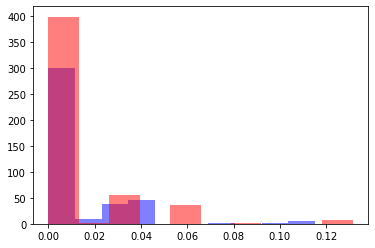

In [34]:
plt.hist(w_output_4_col_NN.flatten(), alpha=0.5,color = "blue",label='predicted data')
plt.hist(w_matrix_true_col.flatten(), alpha=0.5,color = "red",label='real data')
plt.show()

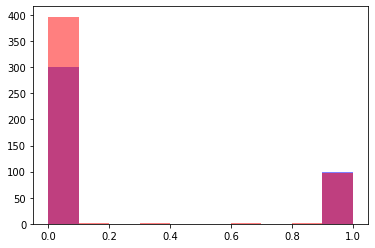

In [35]:
plt.hist(w_output_4_row_NN.flatten(), alpha=0.5,color = "blue",label='predicted data')
plt.hist(w_matrix_true_row.flatten(), alpha=0.5,color = "red",label='real data')
plt.show()